# TP6 : Calibration d’un odomètre
### Auteurs : ARGUELLO Camilo et MASSEREY Romaine

### Introduction

Dans ce TP, notre objectif c'est de faire des ajustements de données prises avec un dispositif de mesure de vistesse où on ne connaît pas les grandeurs physiques. Pour cela on va faire des estimations de valeurs attendues, en comparant avec des valeurs moyennes de vitesse connues. Finalement, l'objectif c'est d'indiquer à quel point le dispositif de mesure est bien calibré.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import qexpy as q
import qexpy.plotting as qplt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

### 1. Ajustement d'histogrammes

On a un dataset avec des mesures de calibration d'un odomètre. Pour chacune des mesures on a une vitesse moyenne connue, à l'exception de la mesure `picinconnu`. 

Pour rendre le dataset plus facile à manipuler, on garde les données dans une liste `vitesses` qui contiennent les vitesses moyennes connues, et une liste `mesures` qui contient les mesures de l'odomètre.

In [3]:
# read the files pic1.csv, pic2.csv, pic3.csv
pic1 = pd.read_csv("pic1.csv", skiprows=0)
pic2 = pd.read_csv("pic2.csv", skiprows=0)
pic3 = pd.read_csv("pic3.csv", skiprows=0)
picinconnu = pd.read_csv("pic_inconnu.csv", skiprows=0)

vitesses = np.array([
    { 'pic': pic1, 'vitesse_moy': 13.9 }, 
    { 'pic': pic2, 'vitesse_moy': 19.4 }, 
    { 'pic': pic3, 'vitesse_moy': 36.1 }
])

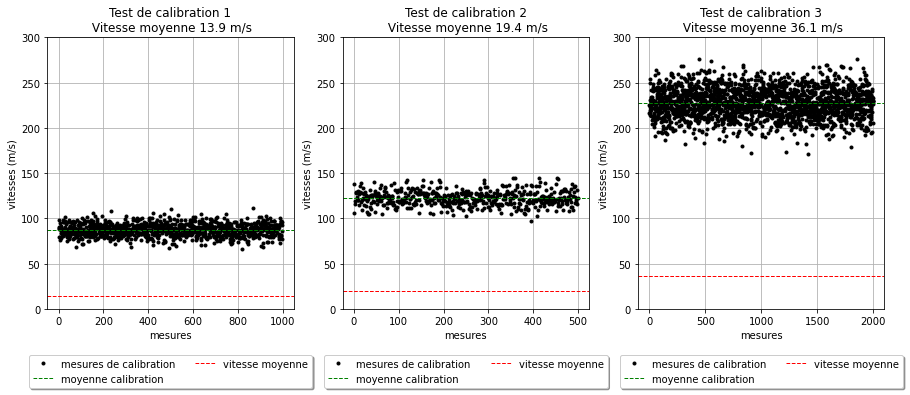

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, v in enumerate(vitesses):
    ax = axes[i]
    ax.plot(v["pic"]["mesures"], '.', color='black', label='mesures de calibration')
    # plot moyenne des mesures de calibration
    ax.axhline(np.mean(v["pic"]["mesures"]), color='g', linestyle='dashed', linewidth=1, label='moyenne calibration')
    # plot vitesses moyennes
    ax.axhline(v["vitesse_moy"], color='r', linestyle='dashed', linewidth=1, label='vitesse moyenne')
    ax.set_xlabel('mesures')
    ax.set_ylabel('vitesses (m/s)')
    ax.set_title('Test de calibration '+str(i+1)+'\n Vitesse moyenne ' + str(v["vitesse_moy"]) + ' m/s')
    ax.grid(True)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    ax.set_ylim(0, 300) # on limite l'axe des y pour mieux voir les points
plt.show()

In [5]:
diff = [np.round(np.abs(v["vitesse_moy"] - np.mean(v["pic"]["mesures"])),2) for v in vitesses]
print("Différences entre la vitesse moyenne et la moyenne des mesures de calibration: ", diff)

Différences entre la vitesse moyenne et la moyenne des mesures de calibration:  [73.5, 103.02, 191.36]


Pour comprendre la structure des données, on fait un graphique qui vérifie de manière visuelle la distribution possible des données. Ceci est très utile pour pouvoir comprendre la dimension et le possible grandeur des données. Et plus tard vérifier à l'aide d'un histogramme. Cette observation montre que la différence entre la valeur moyenne et la valeur médiane de la vitesse est de `73.5` pour la calibration 1, de `103.02` pour la calibration 2 et de `191.36` pour la calibration 3. Il peut s'agir d'un premier indicateur de la qualité de la calibration du dispositif.

Nous validons l'information à l'aide d'un histogramme.

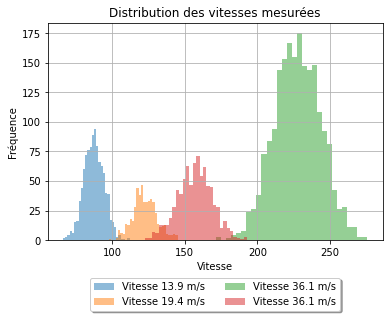

In [6]:
# Lecture des données à partir des fichiers CSV
pic1_data = pd.read_csv('pic1.csv')
pic2_data = pd.read_csv('pic2.csv')
pic3_data = pd.read_csv('pic3.csv')
pic_inconnu_data = pd.read_csv('pic_inconnu.csv')

# Extraction des valeurs de vitesse
pic1_speed = pic1_data['mesures']
pic2_speed = pic2_data['mesures']
pic3_speed = pic3_data['mesures']
pic_inconnu_speed = pic_inconnu_data['mesures']

# Tracé des histogrammes
plt.hist(pic1_speed, bins=30, alpha=0.5, label='Vitesse 13.9 m/s')
plt.hist(pic2_speed, bins=30, alpha=0.5, label='Vitesse 19.4 m/s')
plt.hist(pic3_speed, bins=30, alpha=0.5, label='Vitesse 36.1 m/s')
plt.hist(pic_inconnu_speed, bins=30, alpha=0.5, label='Vitesse 36.1 m/s')

plt.xlabel('Vitesse')
plt.ylabel('Fréquence')
plt.title('Distribution des vitesses mesurées')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()

Il s'agit de trois distributions **gaussiennes**. Les paramètres sont donc la moyenne (qui donne la position centrale de la distribution) et l'écart type (qui mesure la dispersion des données autour de la moyenne). Par exemple, la mesure de calibration 1 et calibration 2, visuellement, n'ont pas une grande dispersion, comparés aux mesures de calibration 3. Ces valeurs seront vérifiées dans la section suivante.

### 1.2 Estimation de la moyenne


#### Mesure de la moyenne statistique

Ce code utilise la fonction np.mean() pour calculer la moyenne et la fonction np.std() pour calculer l'écart-type des valeurs de chaque pic.

In [7]:
# add pic inconnu to the array of vitesses
vitesses = np.append(vitesses, [{ 'pic': picinconnu, 'vitesse_moy': None }])

In [8]:
# Calcul de la moyenne et de l'écart-type pour chaque pic
pic1_mean = np.mean(pic1_speed)
pic1_std = np.std(pic1_speed)
pic2_mean = np.mean(pic2_speed)
pic2_std = np.std(pic2_speed)
pic3_mean = np.mean(pic3_speed)
pic3_std = np.std(pic3_speed)
pic_inconnu_mean = np.mean(pic_inconnu_speed)
pic_inconnu_std = np.std(pic_inconnu_speed)

moyennes_statistique = np.array([pic1_mean, pic2_mean, pic3_mean, pic_inconnu_mean])
ecart_types_statistique = np.array([pic1_std, pic2_std, pic3_std, pic_inconnu_std])

# Affichage des moyennes et des écart-types
print("Pic 1 - Moyenne : {:.2f}, Écart-type : {:.2f}".format(pic1_mean, pic1_std))
print("Pic 2 - Moyenne : {:.2f}, Écart-type : {:.2f}".format(pic2_mean, pic2_std))
print("Pic 3 - Moyenne : {:.2f}, Écart-type : {:.2f}".format(pic3_mean, pic3_std))
print("Pic inconnu - Moyenne : {:.2f}, Écart-type : {:.2f}".format(pic_inconnu_mean, pic_inconnu_std))

Pic 1 - Moyenne : 87.40, Écart-type : 6.88
Pic 2 - Moyenne : 122.42, Écart-type : 8.32
Pic 3 - Moyenne : 227.46, Écart-type : 15.95
Pic inconnu - Moyenne : 157.02, Écart-type : 11.86


Maintenant nouus allons calculer l'erreur sur les moyennes en utilisant la formule de l'erreur standard de la moyenne, qui est donnée par l'écart-type divisé par la racine carrée du nombre d'échantillons. Voici le code qui fait ça:

In [9]:
# Calcul de l'erreur sur les moyennes
pic1_error = pic1_std / np.sqrt(len(pic1_speed))
pic2_error = pic2_std / np.sqrt(len(pic2_speed))
pic3_error = pic3_std / np.sqrt(len(pic3_speed))
pic_inconnu_error = pic_inconnu_std / np.sqrt(len(pic_inconnu_speed))

# Affichage des erreurs sur les moyennes
print("Pic 1 - Erreur sur la moyenne : {:.2f}".format(pic1_error))
print("Pic 2 - Erreur sur la moyenne : {:.2f}".format(pic2_error))
print("Pic 3 - Erreur sur la moyenne : {:.2f}".format(pic3_error))
print("Pic inconnu - Erreur sur la moyenne : {:.2f}".format(pic_inconnu_error))

Pic 1 - Erreur sur la moyenne : 0.22
Pic 2 - Erreur sur la moyenne : 0.37
Pic 3 - Erreur sur la moyenne : 0.36
Pic inconnu - Erreur sur la moyenne : 0.42


Enfin, pour déterminer le pic ayant la moyenne avec l'erreur relative la plus faible, vous pouvez calculer l'erreur relative en divisant l'erreur sur la moyenne par la moyenne elle-même et en prenant la valeur absolue. Le pic avec la plus faible erreur relative sera celui dont la moyenne est la plus précise par rapport à la valeur attendue. Voici comment vous pouvez calculer l'erreur relative pour chaque pic :

In [10]:
# Calcul de l'erreur relative sur les moyennes
pic1_relative_error = np.abs(pic1_error / pic1_mean)
pic2_relative_error = np.abs(pic2_error / pic2_mean)
pic3_relative_error = np.abs(pic3_error / pic3_mean)
pic_inconnu_relative_error = np.abs(pic_inconnu_error / pic_inconnu_mean)

# Affichage des erreurs relatives sur les moyennes
print("Pic 1 - Erreur relative sur la moyenne : {:.2%}".format(pic1_relative_error))
print("Pic 2 - Erreur relative sur la moyenne : {:.2%}".format(pic2_relative_error))
print("Pic 3 - Erreur relative sur la moyenne : {:.2%}".format(pic3_relative_error))
print("Pic inconnu - Erreur relative sur la moyenne : {:.2%}".format(pic_inconnu_relative_error))

Pic 1 - Erreur relative sur la moyenne : 0.25%
Pic 2 - Erreur relative sur la moyenne : 0.30%
Pic 3 - Erreur relative sur la moyenne : 0.16%
Pic inconnu - Erreur relative sur la moyenne : 0.27%


Le pic qui a la plus faible erreur relative est celui dont la moyenne est la plus précise par rapport à la valeur attendue. Dans notre cas, c'est donc le pic 3.

#### Ajustement des données avec `QExPy`

Ajustement des données avec QExPy QExPy possède des méthodes pour ajuster des modèles gaussiens sur des données, comme présenté dans la documentation.
Créer une fonction qui permet d’ajuster un histogramme avec le modèle approprié de QExPy et d’extraire
les valeurs et les erreurs des paramètres de ce modèle. Appliquer cette fonction sur les trois pics de données
et le pic inconnu et sauver les résultats dans des listes. Que valent les corrélations entre les paramètres ?
Commentez sur leur impacts.

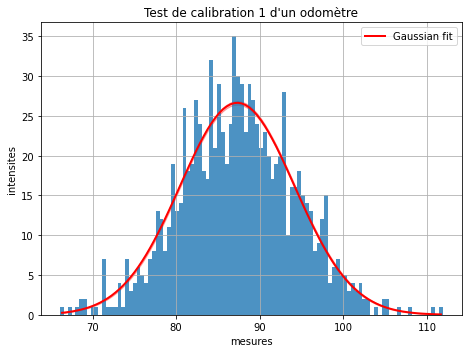

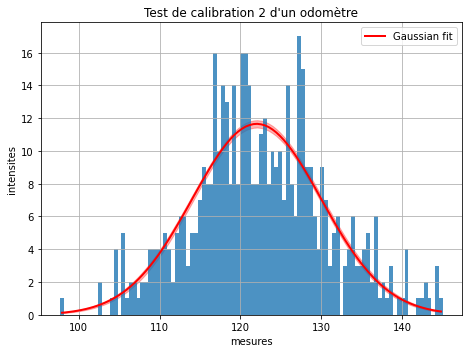

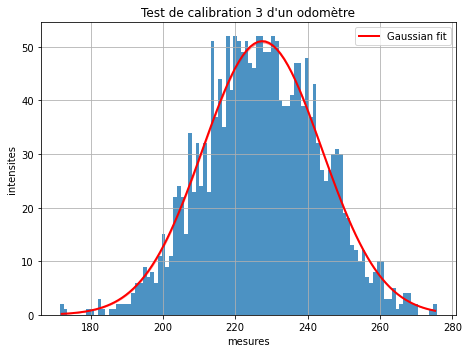

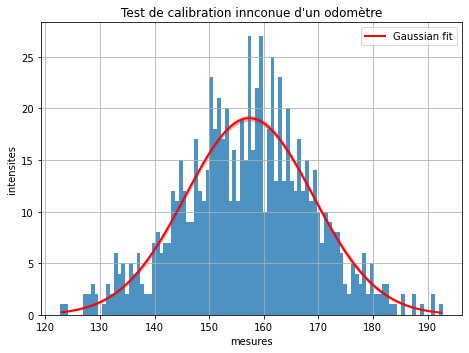

In [11]:
results_qexpy = list()

for i, v in enumerate(vitesses):
    vitesse = np.array(v["pic"]["mesures"])
    n, bins, figure = qplt.hist(vitesse, bins=100)
    result = figure.fit(model=q.FitModel.GAUSSIAN, parguess=[np.max(vitesse), np.mean(vitesse), np.std(vitesse)], color='r', label='Gaussian fit')
    results_qexpy.append(result)
    figure.legend()
    if v["vitesse_moy"] == None:
        figure.title = 'Test de calibration innconue d\'un odomètre'
    else:
        figure.title = 'Test de calibration '+ str(i+1) +' d\'un odomètre'
    figure.xname = 'mesures'
    figure.yname = 'intensites'
    figure.show()

In [17]:
# On récupère les paramètres des gaussiennes
# Les paramètres récupérés sont dans l'ordre: amplitude, moyenne, écart-type
params = [result.params for result in results_qexpy]
qexpy_values = [p.value for param in params for p in param]
qexpy_incertitudes = [p.error for param in params for p in param]

#reshape values to 4x3 matrix (4 gaussians, 3 parameters)
qexpy_values = np.reshape(qexpy_values, (4, 3))
moyennes_qexpy = qexpy_values[:,1]
ecart_types_qexpy = qexpy_values[:,2]

In [13]:
# On a une liste de résultats des moyennes pour chaque pic
# On montre par exemple le résultat pour le premier pic
print(results_qexpy[0])

----------------- Fit Results -------------------
Fit of histogram to gaussian

Result Parameter List: 
normalization = 458 +/- 4,
mean = 87.30 +/- 0.07,
std = 6.86 +/- 0.07

Correlation Matrix: 
[[ 1.000e+00 -2.459e-04  5.777e-01]
 [-2.459e-04  1.000e+00 -3.869e-04]
 [ 5.777e-01 -3.869e-04  1.000e+00]]

chi2/ndof = 0.00/96

--------------- End Fit Results -----------------
----------------- Fit Results -------------------
Fit of histogram to gaussian

Result Parameter List: 
normalization = 233 +/- 4,
mean = 122.0 +/- 0.2,
std = 8.0 +/- 0.2

Correlation Matrix: 
[[1.000e+00 4.532e-04 5.785e-01]
 [4.532e-04 1.000e+00 6.989e-04]
 [5.785e-01 6.989e-04 1.000e+00]]

chi2/ndof = 0.00/96

--------------- End Fit Results -----------------


En analysant les matrices de corrélation (où on a les paramères de normalisation, moyenne et écart-type) on remarque que les valeurs sont similaires pour chaque pic. En effet, par exemple pour la moyenne on obtient presque toujours la même, peu importe la taille du pic et la largeur. 

#### Comparaison des résultats

Dans cette partie nous cherchons à comparer les différentes méthodes d'analyses réalisées précédemment. Nous allons comparer la moyenne statistique trouvée, ainsi que les valeurs moyennes données en faisant un ajustement par `QexPy`. L'objectif est de voir et choisir la meilleur méthode pour s'approcher au mieux de la vraie valeur de vitesse.

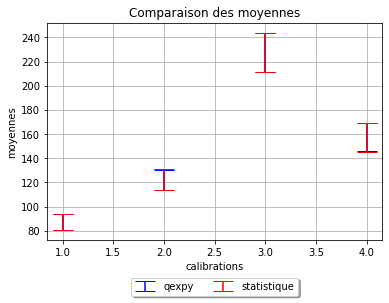

In [18]:

calibration = np.arange(1, 5) # 4 calibrations
# plot error bars
plt.errorbar(calibration, moyennes_qexpy, yerr=ecart_types_qexpy, fmt = 'none', capsize = 10, ecolor = 'blue', label='qexpy')
plt.errorbar(calibration, moyennes_statistique, yerr=ecart_types_statistique, fmt = 'none', capsize = 10, ecolor = 'red', label='statistique')
plt.xlabel('calibrations')
plt.ylabel('moyennes')
plt.title('Comparaison des moyennes')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()

Prémièrement on analyse laquelle des méthodes minimise les erreurs. Sur ce graphe on voit que les bars des erreurs sont plus petites avec l'ajustement par `QuexPy`. Alors, on va prendre ces valeurs moyennes pour trouver la meilleure valeur de calibration de l'odomètre.

#### 1.3 Détermination des paramètres de la calibration

Dans cette partie, nous cherchons à calibrer le détecteur pour pouvoir déduire la vitesse du pic inconnu en fonction de celle des autres. 

À l'aide de la fonction `LinearRegression()`, nous allons donc faire un ajustement linéaire sur les trois pics connus afin d'extraire la vitesse ainsi que l'erreur du pic inconnu.

Coefficients: [0.15839623]
Intercept: 0.07269223596440355


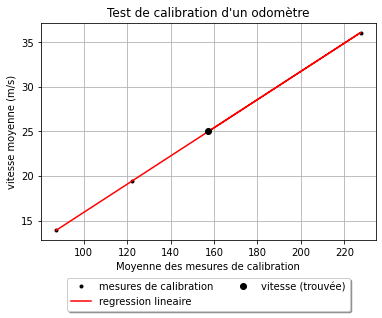

In [19]:
# 1.3 Détermination des paramètres de la calibration

x = np.array([moyennes_qexpy[i] for i,v in enumerate(vitesses) if v['vitesse_moy'] is not None]).reshape(-1, 1)
y = np.array([v['vitesse_moy'] for v in vitesses if v['vitesse_moy'] is not None])

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)

# On récupère les paramètres des gaussiennes
# Ici x_pred correspond aux moyennes des gaussiennes et y_pred à la vitesse moyenne manquante
x_pred = np.array([moyennes_qexpy[i] for i,v in enumerate(vitesses)]).reshape(-1, 1)
y_pred = model.predict(x_pred)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

plt.plot(x, y, '.', color='black', label='mesures de calibration')
plt.plot(x_pred, y_pred,  color='red', label='regression lineaire')

# add a point for the unknown speed
plt.plot(x_pred[3], y_pred[3], 'o', color='black', label='vitesse (trouvée)')

plt.xlabel('Moyenne des mesures de calibration')
plt.ylabel('vitesse moyenne (m/s)')
plt.title('Test de calibration d\'un odomètre')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.show()


En observant ce graphe, on peut déduire d'une manière visuelle que la vitesse du pic inconnu est d'environ $25 \ m/s$.

#### 1.4 Calibration en énergie d'un pic
Il nous reste plus qu'à utiliser la calibration réalisée au-dessus pour afficher la vitesse du pic inconnu en km/h ainsi que son erreur.

In [15]:

# On remplace les valeurs manquantes par les valeurs prédites
for i, v in enumerate(vitesses):
    if v['vitesse_moy'] is None:
        v['vitesse_moy'] = y_pred[i]


In [16]:
def calculate_uncertainty (mesures):
    """
    Cette fonction calcule l'incertitude sur la moyenne d'une série de mesures
    """
    avg = np.mean(mesures)
    std = np.std(mesures) 
    dx = std / np.sqrt(len(mesures))
    d = np.sqrt(dx**2 + dx**2)
    return avg, d

In [17]:
# get moyennes and incertitudes
vitesses_moy = np.array([v['vitesse_moy'] for v in vitesses]) # m/s
avg_vitesses_moy, delta_vitesses_moy = calculate_uncertainty(vitesses_moy) # m/s

# convert to km/h
avg_vitesses_moy_h = avg_vitesses_moy * 3.6
delta_vitesses_moy_h = delta_vitesses_moy * 3.6

print('Vitesse trouvée = {:.3} km/h ± {:.2} km/h'.format(avg_vitesses_moy_h, delta_vitesses_moy_h))


Vitesse trouvée = 85.0 km/h ± 2.1e+01 km/h


### Conclusion

Nous obtenons donc une vitesse de 85 km/h ce qui est résonnable en France même si ici, le lieu où roule la voiture n'est pas spécifié. Ainsi, on montre qu'à partir des données de calibration d'un odomètre, on peut trouver la vitesse d'un pic inconnu en réalisant un ajustement linéaire.